In [2]:
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
import numpy as np

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import MapDataset
from gammapy.estimators import FluxPointsEstimator
from gammapy.makers import FoVBackgroundMaker, MapDatasetMaker, SafeMaskMaker
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    FoVBackgroundModel,
    PointSpatialModel,
    GaussianSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.utils.check import check_tutorials_setup
from gammapy.visualization import plot_npred_signal
from astroquery.simbad import Simbad
from gammapy.estimators import ExcessMapEstimator, TSMapEstimator
import yaml

from tqdm.auto import tqdm

from gammapy_tools.templates import get_config
from gammapy_tools.make_background import *
import gammapy_tools.make_background as bkg
from gammapy_tools.analysis import *

## Make 3D bkgs

In [ ]:
with open('3d_config.yaml', 'r') as f:
    config =yaml.safe_load(f)
config

In [ ]:
data_store_bkgs = DataStore.from_dir(config["io"]["in_dir"])

if config['io']['from_runlist']:
    obs_ids = np.genfromtxt(config['io']['runlist'],dtype=int,unpack=True)
    
else:
    obs_ids = data_store_bkgs.obs_ids
    
print(obs_ids)

In [ ]:
for obs in tqdm(obs_ids):
    get_background_for_run((obs,config))

# FoV analysis

In [3]:
data_store = DataStore.from_dir("/raid/romulus/swong/mydl3/crabtestbkgs3d/")

In [4]:
source_pos = SkyCoord(83.6287500,22.0123611,unit='deg')
#source_pos = SkyCoord.from_name('Mrk 501')
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=source_pos.ra,
    lat=source_pos.dec,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

In [5]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])

In [6]:
energy_axis = MapAxis.from_energy_bounds(0.1, 30., 10, unit="TeV")

geom = WcsGeom.create(
    skydir=source_pos,
    binsz=0.01,
    width=(3, 3),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

In [7]:
energy_axis_true = MapAxis.from_energy_bounds(
    0.005, 200, 100, unit="TeV", name="energy_true"
)

In [8]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="crab-stacked"
)


In [9]:
simbad = Simbad()
simbad.reset_votable_fields()
simbad.add_votable_fields('ra', 'dec', "flux(B)", "flux(V)", "jp11")
simbad.remove_votable_fields('coordinates')

srcs_tab = simbad.query_region(source_pos, radius=1.5*u.deg)
srcs_tab = srcs_tab[srcs_tab["FLUX_B"]<6]
srcs_tab = srcs_tab[srcs_tab["FLUX_V"]!=np.ma.masked]
srcs_tab

MAIN_ID,RA,DEC,FLUX_B,FLUX_V,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",mag,mag,
object,str13,str13,float32,float32,int32
* zet Tau,05 37 38.6854,+21 08 33.158,2.84,3.03,1


In [10]:
exc = []
for star in srcs_tab:
    pos = SkyCoord(star["RA"], star["DEC"], frame="fk5", unit=(u.hourangle, u.deg))
    star = CircleSkyRegion(center=pos, radius=0.3 * u.deg)
    exc.append(star)

In [17]:
offset_max = 1.5 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-default"], offset_max=offset_max, aeff_percent=10
)

circle = CircleSkyRegion(center=source_pos, radius=0.35 * u.deg)
exc.append(circle)
exclusion_mask = ~geom.region_mask(regions=exc)
maker_fov = FoVBackgroundMaker(method="scale", exclusion_mask=exclusion_mask)

In [18]:
exclusion_mask.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [46]:
for obs in observations:
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(stacked, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f} +/-  {dataset.background_model.spectral_model.norm.error:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

print(stacked)


Background norm obs 64080: 1.12 +/-  0.04
Background norm obs 64081: 1.10 +/-  0.04
Background norm obs 64082: 0.93 +/-  0.04
Background norm obs 64083: 1.18 +/-  0.05
MapDataset
----------

  Name                            : crab-stacked 

  Total counts                    : 17159 
  Total background counts         : 11528.97
  Total excess counts             : 5630.03

  Predicted counts                : 13364.70
  Predicted background counts     : 11319.73
  Predicted excess counts         : 1943.45

  Exposure min                    : 9.01e-03 m2 s
  Exposure max                    : 2.90e+09 m2 s

  Number of total bins            : 900000 
  Number of fit bins              : 861658 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 119063.83

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : crab
    Datasets names            :

# Get significance & counts

This needs to be run before the modelling stuff so that the source isn't subtracted!

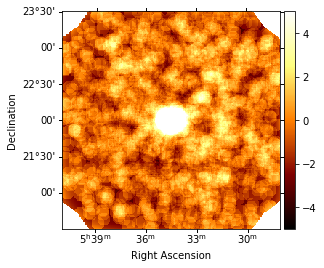

In [14]:
estimator = ExcessMapEstimator(
    correlation_radius=np.sqrt(0.008)*u.deg,
    selection_optional=[],
    correlate_off=False
)

result = estimator.run(stacked)
result["sqrt_ts"].plot(add_cbar=True,vmin=-5,vmax=5)
plt.show()

In [54]:
# ignore the insane amount of sig figs - too lazy to reformat right now

sigma = result['sqrt_ts'].get_by_coord((source_pos.ra,source_pos.dec,1*u.TeV))[0]
counts = result["counts"].get_by_coord([source_pos.ra, source_pos.dec, 1 * u.TeV])[0]
off = result["npred_background"].get_by_coord([source_pos.ra, source_pos.dec, 1 * u.TeV])[0]
print(f'significance: {sigma}, counts: {counts}, off counts: {off}')

significance: 3.0605862140655518, counts: 846.0, off counts: 760.0728149414062


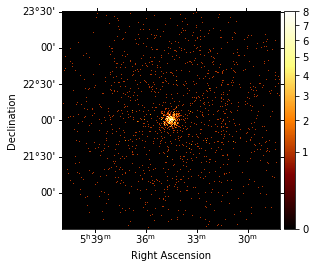

In [113]:
stacked.counts.sum_over_axes().plot(stretch="sqrt", add_cbar=True)
plt.show()

In [22]:
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-default"], offset_max=offset_max, aeff_percent=0.1
)
spatial_model = GaussianSpatialModel(
    lon_0=source_pos.ra, lat_0=source_pos.dec, sigma=np.sqrt(0.008)/1.58*u.deg, frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.2,
    amplitude=4.712e-12 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

#spectral_model = ExpCutoffPowerLawSpectralModel(
#    index=2,
#    amplitude=3e-12 * u.Unit("cm-2 s-1 TeV-1"),
#    reference=1.0 * u.TeV,
#    lambda_ = 0.02/u.TeV
#)

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="crab"
)

#spatial_model.sigma.frozen = True
spatial_model.lon_0.frozen = True
spatial_model.lat_0.frozen = True

bkg_model = FoVBackgroundModel(dataset_name="crab-stacked")

In [23]:
stacked.models = [sky_model, bkg_model]

In [24]:
stacked.models['crab-stacked-bkg'].parameters['tilt'].frozen = False

In [25]:
stacked.models

In [26]:
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run([stacked])

W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 1382.08 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -0.00146987
W MnPosDef Added to diagonal of Error matrix a value 0.501471
W VariableMetricBuilder gdel = -2.35541e+06


/homes/wang/swong/.local/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/homes/wang/swong/.local/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/homes/wang/swong/.local/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/homes/wang/swong/.local/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/homes/wang/swong/.local/lib/python3.9/site-packages/gammapy/maps/wcs/ndmap.py:932: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output

W FCN result is NaN for [ 399.815 55.1339 416.805 519.512 760.155 ]


/homes/wang/swong/.local/lib/python3.9/site-packages/gammapy/maps/wcs/ndmap.py:932: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return scipy.signal.convolve(image, kernel, method=method, mode=mode)
/homes/wang/swong/.local/lib/python3.9/site-packages/gammapy/maps/wcs/ndmap.py:932: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return scipy.signal.convolve(image, kernel, method=method, mode=mode)
/homes/wang/swong/.local/lib/python3.9/site-packages/gammapy/maps/wcs/ndmap.py:932: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return scipy.signal.convolve(image, kernel, method=method, mode=mode)
/homes/wang/swong/.local/lib/python3.9/site-packages/gammapy/maps/wcs/ndmap.py:932: RuntimeWarning: Use of fft convolution on inpu

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 62806.5 Requested 0.0002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00483097 Requested 0.0002
W VariableMetricBuilder FunctionMinimum is invalid after second try
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000506326 is smaller than machine limit 0.00379555 while 0.0002 was requested


In [27]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 374
	total stat : 63678.69

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [28]:
stacked.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str16,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
crab,,index,2.4017e+00,,2.943e-02,nan,nan,False,False,,
crab,,amplitude,3.6726e-11,TeV-1 s-1 cm-2,1.246e-12,nan,nan,False,True,,
crab,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
crab,,lon_0,8.3629e+01,deg,0.000e+00,nan,nan,True,False,,
crab,,lat_0,2.2012e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,,
crab,,sigma,3.4215e-05,deg,2.130e-05,0.000e+00,nan,False,False,,
crab,,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,,
crab,,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,,
crab-stacked-bkg,,norm,9.4724e-01,,2.554e-02,nan,nan,False,True,,


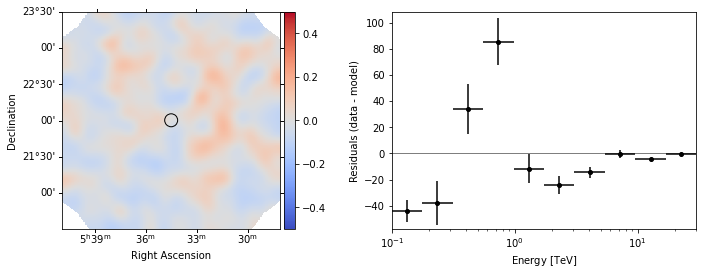

In [29]:
region = CircleSkyRegion(spatial_model.position, radius=0.08944271909999159 * u.deg)
stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
)
plt.show()

In [30]:
stacked.stat_sum()

63678.6946694422

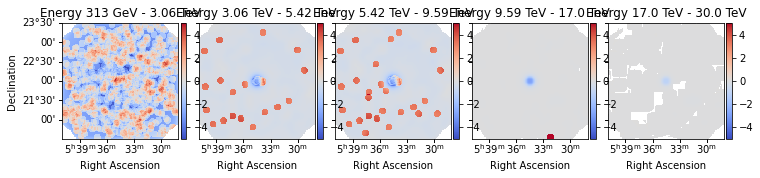

In [31]:
estimator = ExcessMapEstimator(
    correlation_radius=np.sqrt(0.008)*u.deg,
    selection_optional=[],
    energy_edges=np.linspace(0.25,30,10) * u.TeV,
)

result = estimator.run(stacked)
result["sqrt_ts"].plot_grid(
    figsize=(12, 4), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=5
)
plt.show()

# Get spectrum and compare with ED

ED results are manually input into the `ed_model`

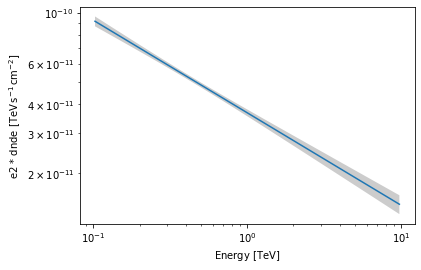

In [32]:
spec = sky_model.spectral_model

energy_bounds = [0.1, 10] * u.TeV
spec.plot(energy_bounds=energy_bounds, energy_power=2)
ax = spec.plot_error(energy_bounds=energy_bounds, energy_power=2)
plt.show()

In [33]:
ed_model = PowerLawSpectralModel(index=2.43,amplitude=3.19e-11*u.Unit("cm-2 s-1 TeV-1"))
ed_model.index.error = 0.05
ed_model.amplitude.error = 1.72e-12*u.Unit("cm-2 s-1 TeV-1")

In [34]:
mrk501_model = PowerLawSpectralModel(index=2.45,amplitude=7.64e-12*u.Unit("cm-2 s-1 TeV-1"))
mrk501_model.index.error = 0.03
mrk501_model.amplitude.error = 2.11e-13

No dataset contribute in range 0.251188643150958 TeV-0.3981071705534973 TeV
No dataset contribute in range 2.5118864315095806 TeV-3.9810717055349736 TeV


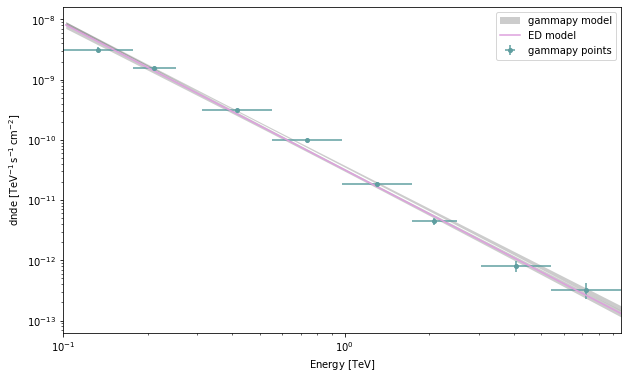

In [35]:
plt.figure(figsize=(10,6))
energy_edges = np.logspace(-1,1,11) * u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source="crab")
flux_points = fpe.run(datasets=[stacked])

ax = spec.plot_error(energy_bounds=energy_bounds, energy_power=0,color='darkseagreen', label='gammapy model')
flux_points.plot(ax=ax, energy_power=0,color='cadetblue', label='gammapy points')
ed_model.plot(energy_bounds,color='plum', label='ED model')
ed_model.plot_error(energy_bounds,color='plum')
plt.legend()
plt.show()

In [36]:
integral_flux = spec.integral_error(0.2*u.TeV,100*u.TeV)
print(integral_flux)

[2.50026583e-10 6.04639255e-12] 1 / (s cm2)


In [37]:
ed_flux = ed_model.integral_error(0.2*u.TeV,100*u.TeV)

<ErrorbarContainer object of 3 artists>

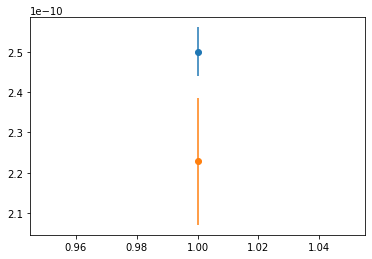

In [38]:
plt.errorbar(1,integral_flux[0],yerr=integral_flux[1],marker='o')
plt.errorbar(1,ed_flux[0],yerr=ed_flux[1],marker='o')

In [39]:
(integral_flux[0].value-ed_flux[0].value)/integral_flux[0].value

0.1088813188452645